# Catalog Size Inspection

In this notebook, we look at methods to explore the size of the parquet files in a hipscat'ed catalog.

This can be useful to determine if your partitioning will lead to imbalanced datasets.

Author: Melissa DeLucchi (delucchi@andrew.cmu.edu)

## Fetch file sizes

First, we fetch the size on disk of all the parquet files in our catalog. This stage may take some time, depending on how many partitions are in your catalog, and the load characteristics of your machine.

In [56]:
from hipscat.catalog.catalog import Catalog
from hipscat.io import paths
import os

### Change this path!!!
catalog_dir = '/data3/epyc/data3/hipscat/catalogs/ztf_jun01/ztf_source'

### ----------------
### You probably won't have to change anything from here.

catalog = Catalog.read_from_hipscat(catalog_dir)

info_frame = catalog.get_pixels().copy()

for index, partition in info_frame.iterrows():
    file_name = result = paths.pixel_catalog_file(catalog_dir, partition['Norder'], partition['Npix'])
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"]/(1024 * 1024 * 1024)

## Summarize pixels and sizes

* healpix orders: distinct healpix orders represented in the partitions
* num partitions: total number of partition files

**Row size data** - using the `num_rows` field in the partition info, check the balance of data. The ideal row ratio is less than 10, but having a larger ratio doesn't mean there's a problem with your data.

* min rows: number of rows in the smallest partition
* max rows: number of rows in the larget partition
* row ratio: max/min - rough indicator of how well your data may balance when distributed across many workers

**Size on disk data** - using the file sizes fetched above, check the balance of your data. If your rows are fixed-width (e.g. no nested arrays, and few NaNs), the ratio here should be similar to the ratio above. If they're very different, and you experience problems when parallelizing operations on your data, you may consider re-structuring the data representation.

* min size_on_disk: smallest file (in GB)
* max size_on_disk: largest file size (in GB)
* size_on_disk ratio: max/min
* total size_on_disk: sum of all parquet catalog files (actual catalog size may vary due to other metadata files)

In [57]:
print(f'healpix orders: {info_frame["Norder"].unique()}')
print(f'num partitions: {len(info_frame["Npix"])}')
print('------')
print(f'min rows: {info_frame["num_rows"].min()}')
print(f'max rows: {info_frame["num_rows"].max()}')
print(f'row ratio: {info_frame["num_rows"].max()/info_frame["num_rows"].min():.2f}')
print('------')
print(f'min size_on_disk: {info_frame["gbs"].min():.2f}')
print(f'max size_on_disk: {info_frame["gbs"].max():.2f}')
print(f'size_on_disk ratio: {info_frame["gbs"].max()/info_frame["gbs"].min():.2f}')
print(f'total size_on_disk: {info_frame["gbs"].sum():.2f}')

healpix orders: [ 2  3  4  5  6  7  8  9 10]
num partitions: 311037
------
min rows: 2
max rows: 3999939
row ratio: 1999969.50
------
min size_on_disk: 0.00
max size_on_disk: 0.06
size_on_disk ratio: 4126.02
total size_on_disk: 7978.47


## File size distribution

Below we look at histograms of file sizes.

In our initial testing, we find that there's a "sweet spot" file size of 100MB-1GB. Files that are smaller create more overhead for individual reads. Files that are much larger may create slow-downs when cross-matching between catalogs. Files that are *much* larger can create out-of-memory issues for dask when loading from disk.

The majority of your files should be in the "sweet spot", and no files in the "too-big" category.

small-ish 	: 311037 	(100.0 %)
sweet-spot 	: 0 	(0.0 %)
big-ish 	: 0 	(0.0 %)
too-big 	: 0 	(0.0 %)


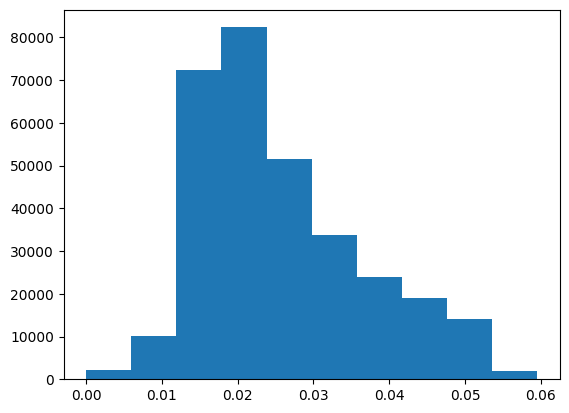

In [58]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(info_frame["gbs"])

bins = [0,.5,1,2,100]
labels = ["small-ish", "sweet-spot", "big-ish", "too-big"]
hist = np.histogram(info_frame["gbs"], bins=bins)[0]
pcts = hist / len(info_frame)
for i in range(0, len(labels)):
    print(f"{labels[i]} \t: {hist[i]} \t({pcts[i]*100:.1f} %)")